In [92]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
from torch.utils.data.dataset import Dataset
import numpy as np
from sklearn.metrics import f1_score
import random

In [93]:
import matplotlib.pyplot as plt

def imshow_pair(im, gdt):
    f, ax = plt.subplots(1, 2, figsize=(12,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [94]:
data_path = 'data/DRIVE/'

In [95]:
im_list = pd.read_csv(osp.join(data_path, 'train.csv')).vessel_paths.values
mask_list = pd.read_csv(osp.join(data_path, 'train.csv')).mask_paths.values

In [96]:
# im_list = ['../'+n for n in im_list]

In [97]:
im1, im2 = Image.open(im_list[0]), Image.open(im_list[3])
mask1 = Image.open(mask_list[0])

In [98]:
im_list[0], mask_list[0]

('data/DRIVE/manual/21_manual1.gif', 'data/DRIVE/mask/21_mask.gif')

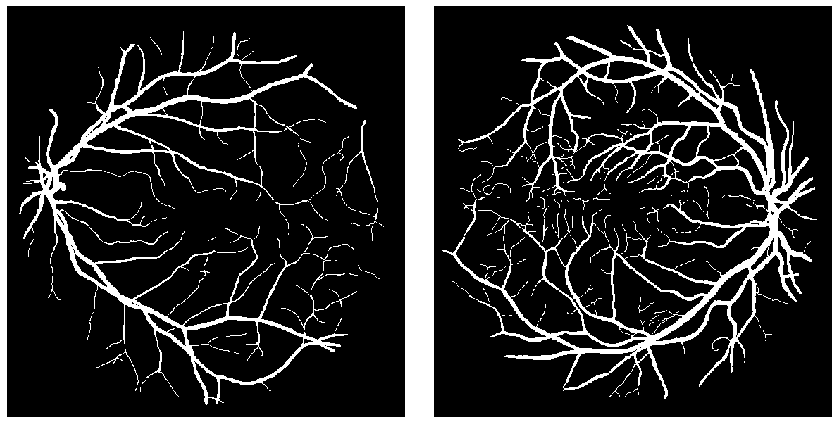

In [99]:
imshow_pair(im1,im2)

In [100]:
def mutual_information(im1, im2):
    # assumes images contain integer values in [0,255]
    X = np.array(im1).astype(float)
    Y = np.array(im2).astype(float)
    hist_2d, _, _ = np.histogram2d(X.ravel(),Y.ravel(),bins=255)
    pxy = hist_2d / float(np.sum(hist_2d)) # joint probability distribution
    
    px = np.sum(pxy, axis=1) # marginal distribution for x over y
    py = np.sum(pxy, axis=0) # marginal distribution for y over x
    
    Hx = - sum(px*np.log(px + (px==0))) # Entropy of X
    Hy = - sum(py*np.log(py + (py==0))) # Entropy of Y
    Hxy = np.sum(-(pxy*np.log(pxy+(pxy==0))).ravel())# Joint Entropy
    
    
    M = Hx+Hy-Hxy # mutual information
    nmi = 2*(M/(Hx+Hy)) # normalized mutual information
    return nmi

In [101]:
# same in sklearn, 4 times slower:
# from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
# normalized_mutual_info_score(np.array(im1).ravel(), np.array(im2).ravel())

In [102]:
mutual_information(im1, im2)

0.0013192554638837512

# Process patches, put them back

In [103]:
import skimage
skimage.__version__

'0.16.2'

In [104]:
from skimage.morphology import binary_erosion, binary_closing, selem
from skimage import img_as_ubyte
from skimage.metrics import structural_similarity as ssim, variation_of_information, mean_squared_error

In [105]:
def erode_patch(patch):
    k = np.random.randint(0, 3) * 2 + 3
    return 255*binary_erosion(patch, selem=selem.rectangle(k, k))

In [106]:
def close_patch(patch):
    k = np.random.randint(0, 3) * 2 + 3
    return 255*binary_closing(patch, selem=selem.rectangle(k, k))

In [107]:
def process_patch(im, xi, yi, patch_size):
    im[yi:yi+patch_size[0], xi:xi+patch_size[1]] = erode_patch(im[yi:yi+patch_size[0], xi:xi+patch_size[1]])
    return im

In [108]:
def degrade_im(im, max_n_patches=20, max_patch_size=(64,64)):
    im = np.array(im)
    h,w = im.shape
    n_patches = np.random.randint(max_n_patches)
    print(n_patches)
    for i in range(n_patches):
        patch_size_h = np.random.randint(3, max_patch_size[0]) # min size of a patch is 3
        patch_size_w = np.random.randint(3, max_patch_size[1])
        
        xi = np.random.randint(0, h - patch_size_h)
        yi = np.random.randint(0, w - patch_size_w)
        
        im = process_patch(im, xi, yi, [patch_size_h, patch_size_w])
    return im

In [109]:
def compute_similarity(im, im_deg, sim_method='mutual_info'):
    im = np.array(im)
    im_deg = np.array(im_deg)
    if sim_method == 'mutual_info':
        return mutual_information(im, im_deg)
    elif sim_method == 'dice':
        return f1_score(im.astype(bool).ravel(), im_deg.astype(bool).ravel())
    elif sim_method == 'ssim':
        return ssim(im.astype(bool), im_deg.astype(bool))
    elif sim_method=='var_info':
        under_seg, over_seg = variation_of_information(im.astype(bool), im_deg.astype(bool))
        return 1-(under_seg + over_seg)
    elif sim_method == 'mse':
        return 1-mean_squared_error(im.astype(bool).ravel(), im_deg.astype(bool).ravel())

22
0.9069882797159925
0.0


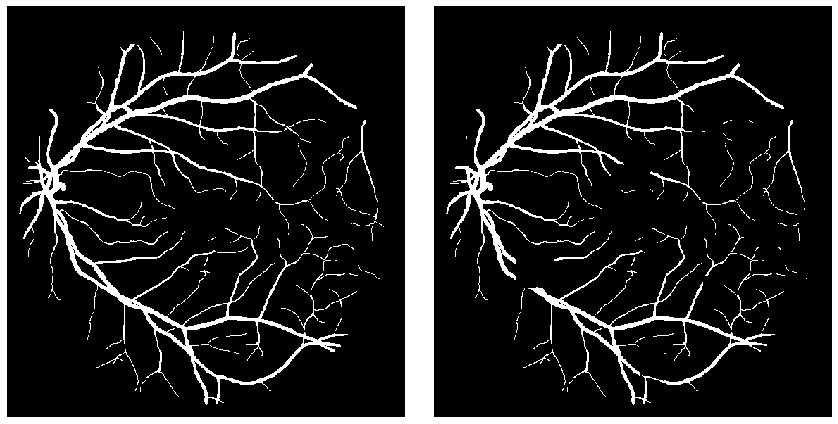

In [110]:
im_deg = degrade_im(im1, max_n_patches=50)
imshow_pair(im1, im_deg)
print(compute_similarity(im1, im_deg, sim_method='mutual_info'))
print(compute_similarity(im1, np.ones_like(im_deg), sim_method='mutual_info'))

## Dataset

In [111]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as tr

from skimage.measure import regionprops

In [112]:
tg_size = 512,512

In [113]:
def degrade_im(im, max_n_patches=20, max_patch_size=(64,64)):
    im = np.array(im)
    h,w = im.shape
    n_patches = np.random.randint(max_n_patches)
    print(n_patches)
    for i in range(n_patches):
        patch_size_h = np.random.randint(3, max_patch_size[0]) # min size of a patch is 3
        patch_size_w = np.random.randint(3, max_patch_size[1])
        
        xi = np.random.randint(0, h - patch_size_h)
        yi = np.random.randint(0, w - patch_size_w)
        
        im = process_patch(im, xi, yi, [patch_size_h, patch_size_w])
    return im

In [114]:
class TrainDataset(Dataset):
    def __init__(self, csv_path, transforms=None, label_values=None):
        df = pd.read_csv(csv_path)
        self.vessels_list = df.vessel_paths
        self.mask_list = df.mask_paths
        self.transforms = transforms

    def crop_to_fov(self, vessels, mask):
        minr, minc, maxr, maxc = regionprops(np.array(mask))[0].bbox
        vessels_crop = Image.fromarray(np.array(vessels)[minr:maxr, minc:maxc])
        return vessels_crop

    def __getitem__(self, index):
        # load image and labels
        vessels = Image.open(self.vessels_list[index]).convert('L')
        mask = Image.open(self.mask_list[index]).convert('L')
        vessels = self.crop_to_fov(vessels, mask)
        if self.transforms is not None:
            vessels = self.transforms(vessels)
            
        vessels_deg = degrade_im(vessels, max_n_patches=50)
        sim = compute_similarity(vessels, vessels_deg, sim_method='mutual_info')

        return tr.ToTensor()(Image.fromarray(vessels_deg)), sim

    def __len__(self):
        return len(self.vessels_list)

In [115]:
path_train_csv = osp.join(data_path, 'train.csv')
path_val_csv = osp.join(data_path, 'val.csv')

train_dataset = TrainDataset(csv_path=path_train_csv)
val_dataset = TrainDataset(csv_path=path_val_csv)
# transforms definition
size = tg_size
# required transforms
resize = tr.Resize(size)
tensorizer = tr.ToTensor()
# geometric transforms
h_flip = tr.RandomHorizontalFlip()
v_flip = tr.RandomVerticalFlip()
rotate = tr.RandomRotation(degrees=45, fill=(0,))
scale = tr.RandomAffine(degrees=0, scale=(0.95, 1.20))
transl = tr.RandomAffine(degrees=0, translate=(0.05, 0))
# either translate, rotate, or scale
scale_transl_rot = tr.RandomChoice([scale, transl, rotate])

train_transforms = tr.Compose([resize,  scale_transl_rot, h_flip, v_flip])
val_transforms = tr.Compose([resize])
train_dataset.transforms = train_transforms
val_dataset.transforms = val_transforms

In [116]:
im, sim = train_dataset[0]
im2, sim2 = train_dataset[0]

10
40


0.9619703560297717 0.8421675704205072


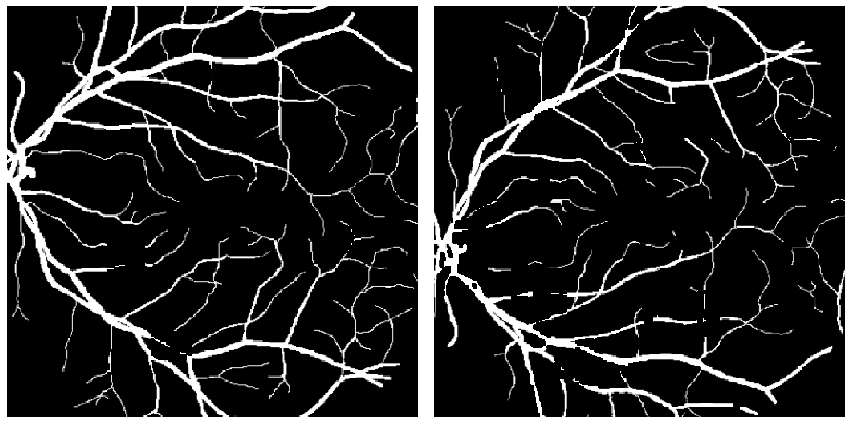

In [117]:
imshow_pair(im.numpy()[0], im2.numpy()[0])
print(sim, sim2)

## Dataset with synthetic examples

In [118]:
from utils import paired_transforms_tv04 as tr

In [119]:
class TrainDataset(Dataset):
    def __init__(self, csv_path, p_manual=0.5, p_nothing=0.1, max_deg_patches=50, max_patch_size=(64,64), 
                 sim_method='mutual_info', transforms=None):
        df = pd.read_csv(csv_path)
        self.p_manual=p_manual
        self.p_nothing=p_nothing
        self.max_deg_patches = max_deg_patches
        self.max_patch_size = max_patch_size
        self.vessels_list = df.vessel_paths
        self.mask_list = df.mask_paths
        self.sim_method = sim_method
        self.transforms = transforms

    def crop_to_fov(self, vessels, mask):
        minr, minc, maxr, maxc = regionprops(np.array(mask))[0].bbox
        vessels_crop = Image.fromarray(np.array(vessels)[minr:maxr, minc:maxc])
        return vessels_crop
    
    def compute_similarity(self, im, im_deg, sim_method='mutual_info'):
        im = np.array(im)
        im_deg = np.array(im_deg)
        if sim_method == 'mutual_info':
            return mutual_information(im, im_deg)
        elif sim_method == 'dice':
            return f1_score(im.astype(bool).ravel(), im_deg.astype(bool).ravel())
        elif sim_method == 'ssim':
            return ssim(im.astype(bool), im_deg.astype(bool))
        elif sim_method=='var_info':
            under_seg, over_seg = variation_of_information(im.astype(bool), im_deg.astype(bool))
            return 1-(under_seg + over_seg)
        elif sim_method == 'mse':
            return 1-mean_squared_error(im.astype(bool).ravel(), im_deg.astype(bool).ravel())

    def erode_patch(self, patch):
        k = np.random.randint(0, 3) * 2 + 3 # 3, 5, 7
        return 255*binary_erosion(patch, selem=selem.rectangle(k, k))

    def process_patch(self, im, xi, yi, patch_size):
        im[yi:yi+patch_size[0], xi:xi+patch_size[1]] = self.erode_patch(im[yi:yi+patch_size[0], xi:xi+patch_size[1]])
        return im
    
    def degrade_im(self, im, max_n_patches=100, max_patch_size=(64,64)):
        im = np.array(im)
        h,w = im.shape
        n_patches = np.random.randint(max_n_patches)
        for i in range(n_patches):
            patch_size_h = np.random.randint(3, max_patch_size[0]) # min size of a patch is 3
            patch_size_w = np.random.randint(3, max_patch_size[1])

            xi = np.random.randint(0, h - patch_size_h)
            yi = np.random.randint(0, w - patch_size_w)

            im = self.process_patch(im, xi, yi, [patch_size_h, patch_size_w])
        return im

    def __getitem__(self, index):
        # load image and labels
        vessel_path = self.vessels_list[index]
        vessels_original = Image.open(vessel_path).convert('L')
        mask = Image.open(self.mask_list[index]).convert('L')
        vessels_original = self.crop_to_fov(vessels_original, mask)
        
        if random.random() > 1-self.p_nothing: 
                # we do not degrade, similarity=1, return now
                print('Do nothing')
                rsz = train_dataset.transforms.transforms[0]
                return tr.ToTensor()(rsz(vessels_original)), 1, tr.ToTensor()(rsz(vessels_original))
            
        if random.random() > self.p_manual:
            # we return an artificial example
            epoch=random.choice([20,40,60])
            vessel_path = vessel_path.replace('manual/', 'predicted_epoch_'+str(epoch)+'/')
            print('changing paths to',vessel_path)
            vessels_pred = self.crop_to_fov(Image.open(vessel_path).convert('L'), mask)
            if self.transforms is not None:
                vessels_original, vessels_pred = self.transforms(vessels_original, vessels_pred)
            # thresholding only needed for non-binary images (predictions)
            threshold = 255*(random.random()*0.25+0.25) # random threshold in [0.25,0.5]
            
            vessels_pred = np.array(vessels_pred)>threshold
            # we degrade, compute similarity later
            vessels_deg = self.degrade_im(vessels_pred, self.max_deg_patches, self.max_patch_size)
            # transform may introduce perturbations on binary ground-truth
            vessels_original = Image.fromarray(np.array(vessels_original)>0.5)
        else:
            # we degrade, compute similarity later
            vessels_deg = self.degrade_im(vessels_original, self.max_deg_patches, self.max_patch_size)

        sim = self.compute_similarity(vessels_original, vessels_deg, sim_method=self.sim_method)
        return tr.ToTensor()(Image.fromarray(vessels_deg)), sim, tr.ToTensor()(vessels_original)

    def __len__(self):
        return len(self.vessels_list)

In [120]:
path_train_csv = osp.join(data_path, 'train.csv')
path_val_csv = osp.join(data_path, 'val.csv')

# play with p_manual, p_nothing to see how this goes
train_dataset = TrainDataset(csv_path=path_train_csv, p_manual=0.0, p_nothing=1.0, max_deg_patches=50)
val_dataset = TrainDataset(csv_path=path_val_csv, p_manual=0.5, p_nothing=0.1, max_deg_patches=50)

In [121]:
# transforms definition
size = tg_size
# required transforms
resize = tr.Resize(size)
tensorizer = tr.ToTensor()
# geometric transforms
h_flip = tr.RandomHorizontalFlip()
v_flip = tr.RandomVerticalFlip()
rotate = tr.RandomRotation(degrees=45)
scale = tr.RandomAffine(degrees=0, scale=(0.95, 1.20))
transl = tr.RandomAffine(degrees=0, translate=(0.05, 0))
# either translate, rotate, or scale
scale_transl_rot = tr.RandomChoice([scale, transl, rotate])

train_transforms = tr.Compose([resize,  scale_transl_rot, h_flip, v_flip])
val_transforms = tr.Compose([resize])
train_dataset.transforms = train_transforms
val_dataset.transforms = val_transforms

Do nothing


1

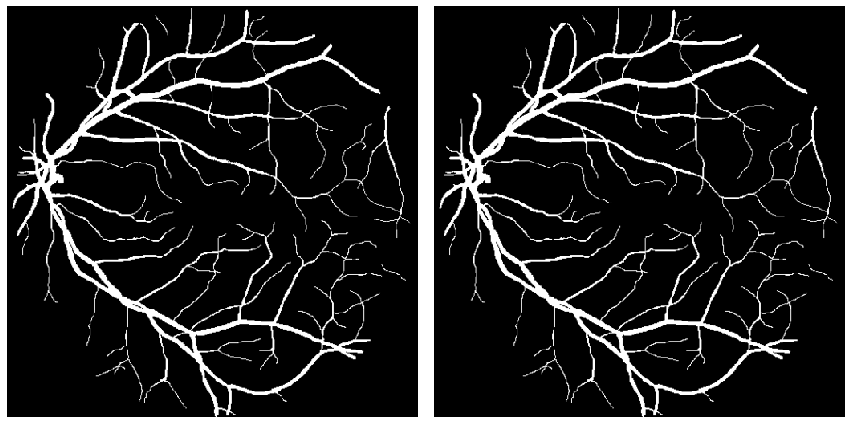

In [122]:
im, sim, true = train_dataset[0]
imshow_pair(true.numpy()[0], im.numpy()[0])
sim

### From File - I have moved resize into the dataset here:

In [123]:
from utils.get_loaders import get_reg_datasets

In [124]:
train_dataset, val_dataset = get_reg_datasets(path_train_csv, path_train_csv, p_manual=0.5, p_nothing=0.1, 
                                              max_deg_patches=50, max_patch_size=(64, 64), 
                                              sim_method='mutual_info', tg_size=(512, 512))

(0.4774826006146505, 0.46823327664814607)

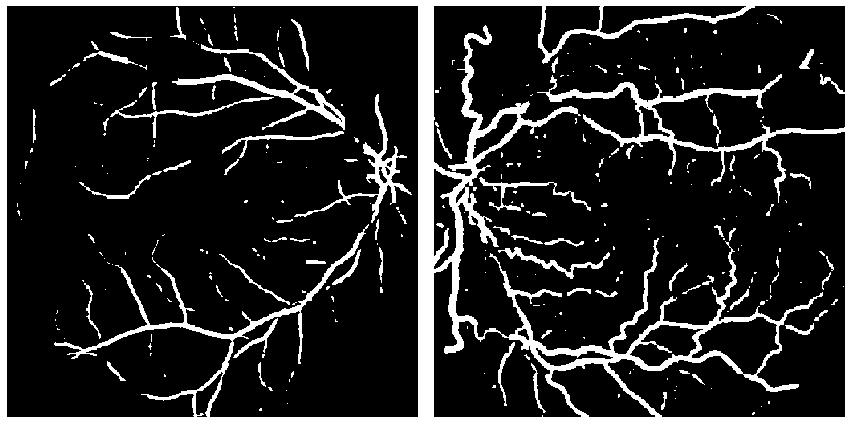

In [125]:
im, sim = train_dataset[0]
im2, sim2 = train_dataset[1]
imshow_pair(im.numpy()[0], im2.numpy()[0])
sim,sim2

In [126]:
im.shape, im2.shape

(torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))

In [127]:
from utils.get_loaders import get_reg_loaders

In [128]:
train_loader, val_loader = get_reg_loaders(path_train_csv, path_train_csv, batch_size=4, 
                                           p_manual=0.5, p_nothing=0.1, max_deg_patches=50,
                                           max_patch_size=(64, 64), sim_method='mutual_info',
                                           tg_size=(512,512))

In [136]:
batch = next(iter(train_loader))
ims, labels = batch[0], batch[1]
ims.shape, labels

(torch.Size([4, 1, 512, 512]), tensor([0.8460, 0.9373, 0.8610, 0.2681]))

# Architectures

In [137]:
from models.get_reg_model import get_arch

In [138]:
model = get_arch(model_name='resnet18', in_channels=1, n_classes=1)

In [140]:
model(ims)

tensor([[0.2611],
        [0.3278],
        [0.3546],
        [0.4189]], grad_fn=<AddmmBackward>)